# Phase 4: Data Mining

## Imports

In [303]:
from cProfile import label
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_text
from sqlalchemy import create_engine

## Helper Functions

In [304]:
# Country Codes List
country_codes = ['CAN', 'USA', 'MEX', 'IRN', 'THA', 'UKR', 'CAF', 'TCD', 'MLI']

# Countries organized by development label
countries_by_class_label = {
      'developed': ['CAN', 'USA'],
      'developing': ['MEX', 'IRN', 'THA', 'UKR'],
      'underdeveloped': ['CAF', 'TCD', 'MLI']
}

plt.rcParams['figure.figsize'] = [10, 10]

def get_country_development_class(country_code):
      if country_code in countries_by_class_label['developed']:
            return "developed"
      elif country_code in countries_by_class_label['developing']:
            return "developing"
      elif country_code in countries_by_class_label['underdeveloped']:
            return "underdeveloped"
      else:
            return np.NaN

def get_country_shape(country_code):
      if country_code in countries_by_class_label['developed']:
            return "s"
      elif country_code in countries_by_class_label['developing']:
            return "o"
      else:
            return "^"
      
def get_country_color(country_code):
      if country_code in countries_by_class_label['developed']:
            return "limegreen"
      elif country_code in countries_by_class_label['developing']:
            return "gold"
      else:
            return "red"

## Pulling Data from Dart Mart (PostgreSQL)

In [305]:
# SQL query to pull data from Postgres for data mining
query_pull_data = '''
SELECT DISTINCT 
       C.country_code, D.year_, 
       F.quality_of_life_index, F.human_development_index, F.income_index,
       C.total_population, C.population_growth, C.gdp_constant_2015, C.gdp_growth,
       ED.literacy_rate, ED.government_expenditure_on_education,
       H.birth_rate, H.death_rate, H.capital_health_expenditure, H.prevalence_of_overweight_female, H.prevalence_of_overweight_male, H.prevalence_of_hypertension_female, H.prevalence_of_hypertension_male,
       P.life_expectancy_female, P.life_expectancy_male, P.life_expectancy, P.net_migration, P.labor_force_total, P.unemployment_rate,
       LV.access_electricity, LV.coverage_social_insurance_programs, LV.access_to_fuels_for_cooking
FROM "CSI4142".fact_table as F, "CSI4142".country as C, "CSI4142".date_ as D, "CSI4142".education as ED, "CSI4142".health as H, "CSI4142".living_conditions as LV, "CSI4142".population_ as P
WHERE F.country_surrogate=C.surrogate_key AND
      F.date_surrogate=D.surrogate_key AND
      F.education_surrogate=ED.surrogate_key AND
      F.health_surrogate=H.surrogate_key AND
      F.living_conditions_surrogate=LV.surrogate_key AND
      F.population_surrogate=P.surrogate_key
ORDER BY C.country_code, D.year_
;
'''

# Pull data into dataframe
db_engine = create_engine('postgresql+psycopg2://bazzadev@localhost/bazzadev')
raw_data = pd.read_sql_query(query_pull_data, db_engine)

## Data Summarization

Let's get a feel for the data that we will be working with.

First, we will display the quality of life index for each country using a boxplot:

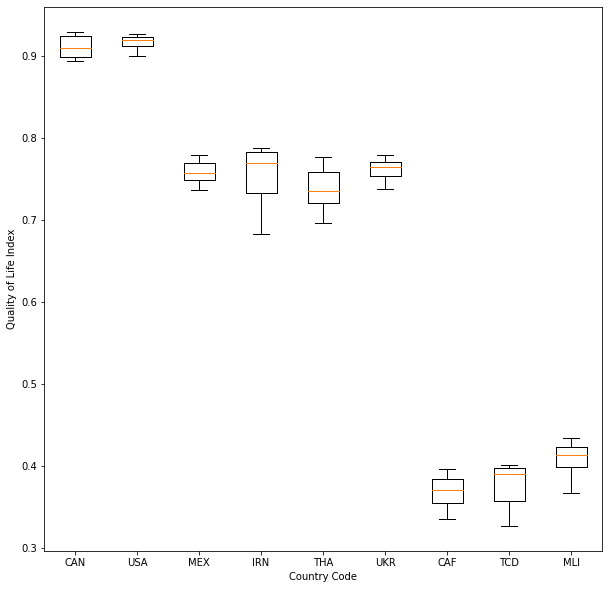

In [306]:
plt.boxplot(
    [raw_data[raw_data['country_code']==code]['quality_of_life_index'] for code in country_codes], 
    labels=country_codes)

plt.xlabel('Country Code')
plt.ylabel('Quality of Life Index')
plt.show()

We can also use a boxplot to visualize the human development index, which is *actually* correlated with the class label (development index).

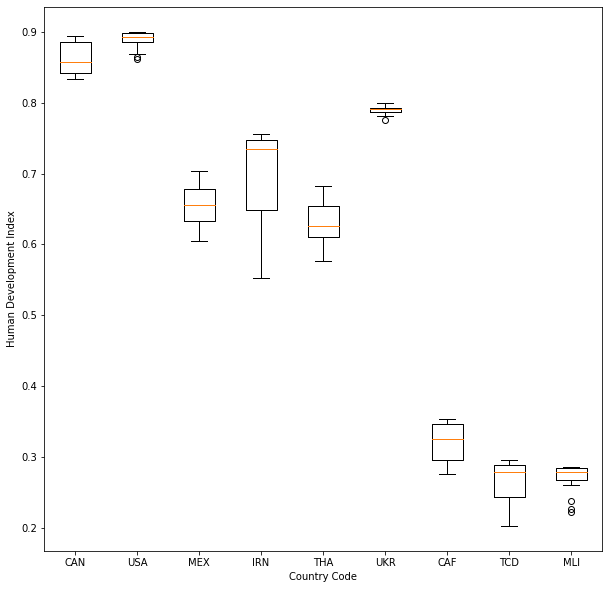

In [307]:
plt.boxplot(
    [raw_data[raw_data['country_code']==code]['human_development_index'] for code in country_codes], 
    labels=country_codes)

plt.xlabel('Country Code')
plt.ylabel('Human Development Index')
plt.show()

Next, we will examine the total labor force for each country using a regular plot:

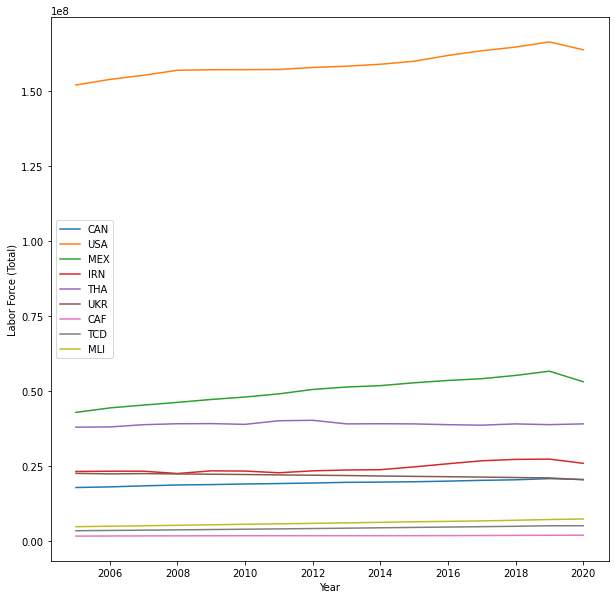

In [308]:
for code in country_codes:
    country_data = raw_data[raw_data['country_code']==code]
    # print(country_data)
    plt.plot(country_data['year_'], country_data['labor_force_total'], label=code)

plt.legend(loc='center left')

plt.xlabel('Year')
plt.ylabel('Labor Force (Total)')
plt.show()

Scatter plot:

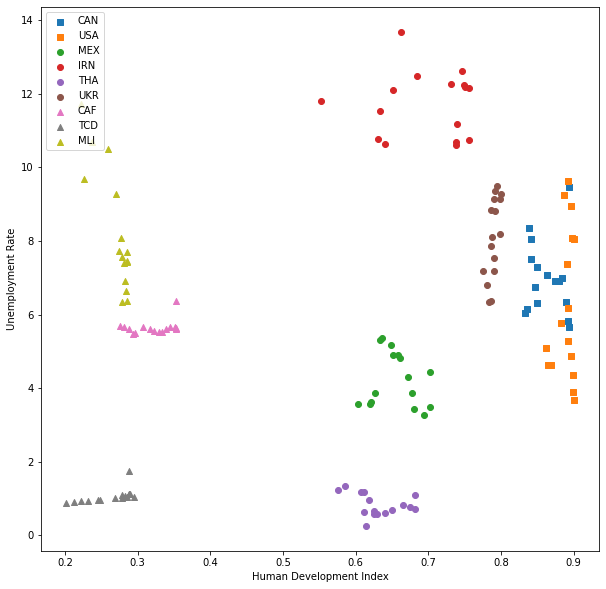

In [309]:
for code in country_codes:
    country_data = raw_data[raw_data['country_code']==code]
    plt.scatter(country_data['human_development_index'], country_data['unemployment_rate'], label=code, marker=get_country_shape(code))

plt.legend(loc='upper left')

plt.xlabel('Human Development Index')
plt.ylabel('Unemployment Rate')
plt.show()

We can also use Seaborn's `pairplot()` function to get an overall view of how the
features in our data interact with each other:

In [310]:
# sns.pairplot(raw_data, corner=True)

## Data Pre-processing

In [311]:
df = raw_data.copy(deep=True)

df.fillna(method='pad', limit=3)
df = df.fillna(method='bfill', limit=3)

imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
imp_cols = df.columns.to_list()[1:]
df[imp_cols] = pd.DataFrame(imp.fit_transform(df[imp_cols]))

df['development_class'] = df.apply(
      lambda row: get_country_development_class(row.country_code),
      axis=1)

df.insert(1, 'development_class', df.pop('development_class'))

le = LabelEncoder()
df['development_class'] = le.fit_transform(df['development_class'])

group_country = df['country_code']

df.pop('country_code')
# df.pop('human_development_index')
# df.pop('quality_of_life_index')
# df.pop('income_index')

# df = pd.get_dummies(df)

feature_cols = df.columns.to_list()[1:]
label = 'development_class'

df[feature_cols] = pd.DataFrame(
      MinMaxScaler().fit_transform(df[feature_cols]), 
      columns=feature_cols)

X = df[feature_cols]
y = df[label]

## Classification

We will be using cross validation to assess the accuracy, precision, and recall 
of the three models we'll be using.

Specifically, we'll be using group $K$-fold cross validation to avoid training and
testing on the same country in any given fold.

First, we write a function which will conduct the cross-validation and performance
assessment for a single model:


In [312]:
def cross_val(X, y, model, cv):
      scores = []
      total_y_test = pd.Series(dtype='int64')
      total_y_pred = pd.Series(dtype='int64')
      
      for train, test in cv.split(X, y, groups=group_country):
            # Get our training and testing data
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
            
            # To prevent overfitting, we re-select best features in each cv iteration
            b = SelectKBest(chi2, k=3)
            b.fit(X_train, y_train)
            best_features = X_train.columns[b.get_support()]
            
            # Select only the best k features for our data
            X_train = X_train[best_features]
            X_test = X_test[best_features]
            
            # Train the model
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            scores.append(score)
            
            # Test the model on our testing set
            y_pred = model.predict(X_test)
            
            # Save the results for our final confusion matrix
            total_y_test = pd.concat([total_y_test, pd.Series(y_test)])
            total_y_pred = pd.concat([total_y_pred, pd.Series(y_pred, index=y_test.index)])
            
            ### Shows confusion matrix and statistics for each less-than-perfect run
            # if score < 1:
            #       feats = pd.Series(best_features, name='Feature')
            #       feat_scores = pd.Series(b.scores_, name='Score')
            #       # print( pd.concat([feats, feat_scores], axis=1).sort_values(by=['Score'], ascending=[False]) )
                  
            #       country = pd.Series(raw_data.iloc[y_test.index]['country_code'], name='Country Code')
            #       actual = pd.Series(y_test, name='Actual')
            #       predicted = pd.Series(y_pred, name='Predicted', index=actual.index)
                  
            #       # print( pd.concat([country, X_test, actual, predicted], axis=1) )
                  
            #       metrics.ConfusionMatrixDisplay.from_predictions(le.inverse_transform(y_test), le.inverse_transform(y_pred), labels=le.classes_)
            #       plt.show()
      
      # Show the confusion matrix
      metrics.ConfusionMatrixDisplay.from_predictions(
            le.inverse_transform(total_y_test), 
            le.inverse_transform(total_y_pred), 
            labels=le.classes_)
      plt.show()
      
      print("Accuracy scores: ", scores)
      print(f"We have a mean accuracy of {np.mean(scores):.2f} and std of {np.var(scores):.2f}\n")
      
      print('Classification Report:\n', metrics.classification_report(le.inverse_transform(total_y_test), le.inverse_transform(total_y_pred)))

Now we can call this function on each of the three models we're using today -- those being:

- Decision tree
- Gradient boosting
- Random forest


### Sanity Tests - Training & Test Splits

Before we get started, we can run some sanity tests to make sure group $k$-fold
validation is splitting our dataset correctly (eg. we do not test on a country we
have observed in the test set):

In [313]:
def run_sanity_tests():
    cv = GroupKFold(n_splits=group_country.nunique())

    for train, test in cv.split(X, y, groups=group_country):
        X.insert(0, 'country_code', group_country.values)
        print(list(X['country_code'].iloc[train]))
        print(list(X['country_code'].iloc[test]))
        print()
        X.pop('country_code')

# run_sanity_tests()

Now that we've done that, we'll run group $k$-fold cross validation for each of 
our classifiers to determine the better model:

In [314]:
cv = GroupKFold(n_splits=group_country.nunique())

### Decision Tree

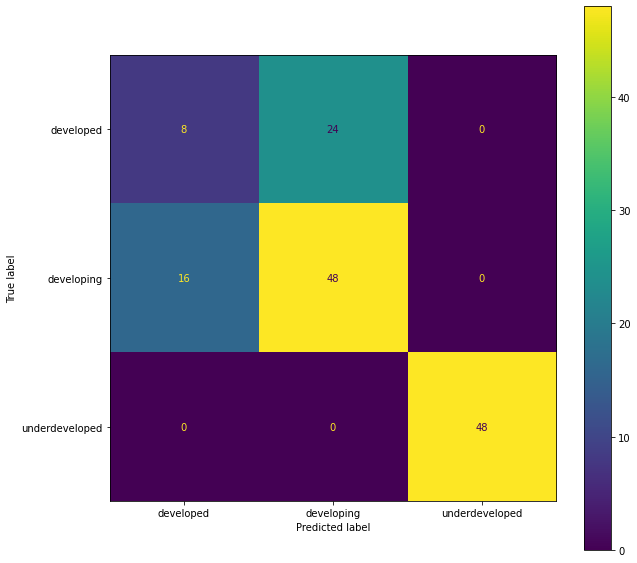

Accuracy scores:  [0.5, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0]
We have a mean accuracy of 0.72 and std of 0.17

Classification Report:
                 precision    recall  f1-score   support

     developed       0.33      0.25      0.29        32
    developing       0.67      0.75      0.71        64
underdeveloped       1.00      1.00      1.00        48

      accuracy                           0.72       144
     macro avg       0.67      0.67      0.66       144
  weighted avg       0.70      0.72      0.71       144



In [315]:
clf = DecisionTreeClassifier()
cross_val(X, y, clf, cv)

### Gradient Boosting

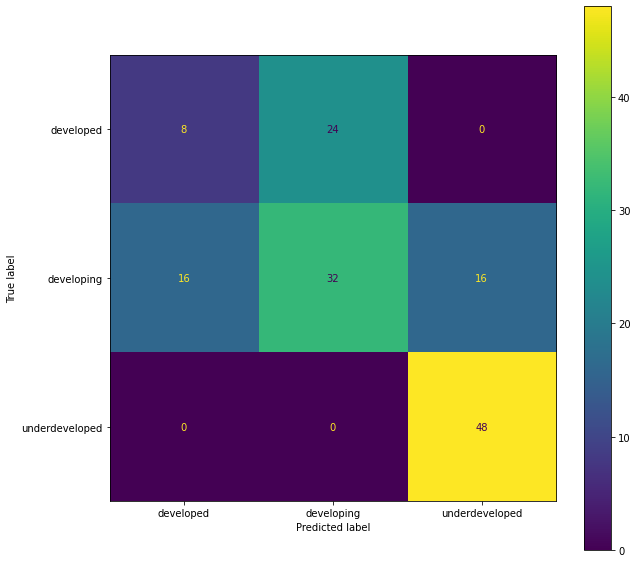

Accuracy scores:  [0.5, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0]
We have a mean accuracy of 0.61 and std of 0.21

Classification Report:
                 precision    recall  f1-score   support

     developed       0.33      0.25      0.29        32
    developing       0.57      0.50      0.53        64
underdeveloped       0.75      1.00      0.86        48

      accuracy                           0.61       144
     macro avg       0.55      0.58      0.56       144
  weighted avg       0.58      0.61      0.59       144



In [316]:
clf = GradientBoostingClassifier()
cross_val(X, y, clf, cv)

### Random Forest

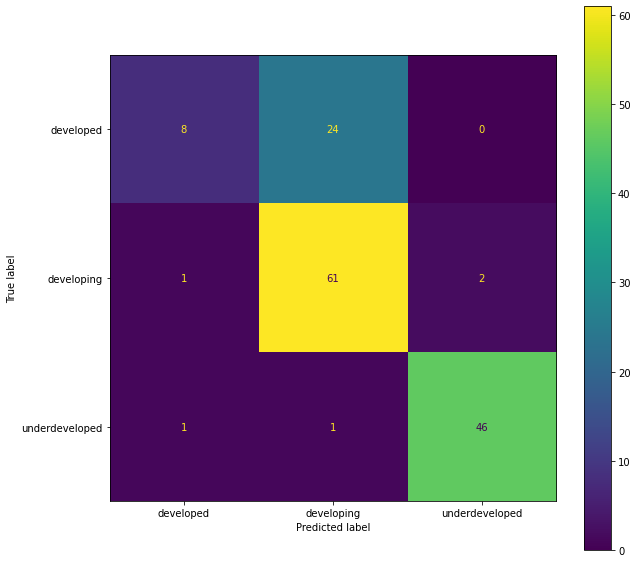

Accuracy scores:  [0.5, 0.9375, 1.0, 0.9375, 1.0, 0.875, 1.0, 0.0, 0.9375]
We have a mean accuracy of 0.80 and std of 0.10

Classification Report:
                 precision    recall  f1-score   support

     developed       0.80      0.25      0.38        32
    developing       0.71      0.95      0.81        64
underdeveloped       0.96      0.96      0.96        48

      accuracy                           0.80       144
     macro avg       0.82      0.72      0.72       144
  weighted avg       0.81      0.80      0.77       144



In [317]:
clf = RandomForestClassifier()
cross_val(X, y, clf, cv)